In [195]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gamma
from scipy.stats import beta
from scipy.special import beta as beta_function
from scipy.special import gamma as gamma_function
from tqdm import tqdm
from scipy.stats import norm

# How to Simulate a $\gamma(a)$ Distribution

We aim to simulate a random variable $X \sim \gamma(a)$, whose probability density function is given by

$$
\gamma(x, a) = \frac{1}{\Gamma(a)} x^{a-1} e^{-x}, \quad x > 0
$$

Let us define the unnormalized density function

$$
f(x) = x^{a-1} e^{-x}
$$

## Bounding $f(x)$

We observe that $f(x)$ can be bounded as follows
$
x^{a-1} e^{-x} \leq
\begin{cases}
x^{a-1}, & \text{if } x \in [0, 1[ \\
e^{-x}, & \text{if } x \in [1, \infty[
\end{cases}
$

Thus, we have
$
f(x) \leq x^{a-1} \mathbb{1}_{[0, 1[} + e^{-x} \mathbb{1}_{[1, \infty[}
$

## Normalizing the Bound

We want $x^{a-1} \mathbb{1}_{[0, 1[} + e^{-x} \mathbb{1}_{[1, \infty[}$ to represent a valid probability density. To ensure this, we calculate its integral over $\mathbb{R}^+$:

$$
\int_{\mathbb{R}^+} \left( x^{a-1} \mathbb{1}_{[0, 1[} + e^{-x} \mathbb{1}_{[1, \infty[} \right) dx
= \left[\frac{x^a}{a}\right]_0^1 + \left[-e^{-x}\right]_1^{\infty}
$$

Evaluating this, we get
$
\frac{1}{a} + \frac{1}{e} = \frac{a + e}{ae}
$

Thus, the normalized bound is given by
$
g(x) = \frac{ae}{a + e} \left( x^{a-1} \mathbb{1}_{[0, 1)} + e^{-x} \mathbb{1}_{[1, \infty)} \right)
$

## Conclusion

It follows that
$
f(x) \leq \underbrace{\frac{a + e}{ae}}_{m} g(x)
$

In [196]:
def gamma_unnormalized_density(x, a):
    """
    Compute the unnormalized density of the gamma distribution.
    """
    return x ** (a - 1) * np.exp(-x)

def gamma_auxiliary_density(x, a):
    """
    Compute the auxiliary density function g(x) used for rejection sampling.
    """
    normalization_constant = (a * np.exp(1)) / (a + np.exp(1))
    g_values = np.empty_like(x, dtype=np.float64)
    g_values[x < 1] = x[x < 1] ** (a - 1)
    g_values[x >= 1] = np.exp(-x[x >= 1])

    return normalization_constant * g_values

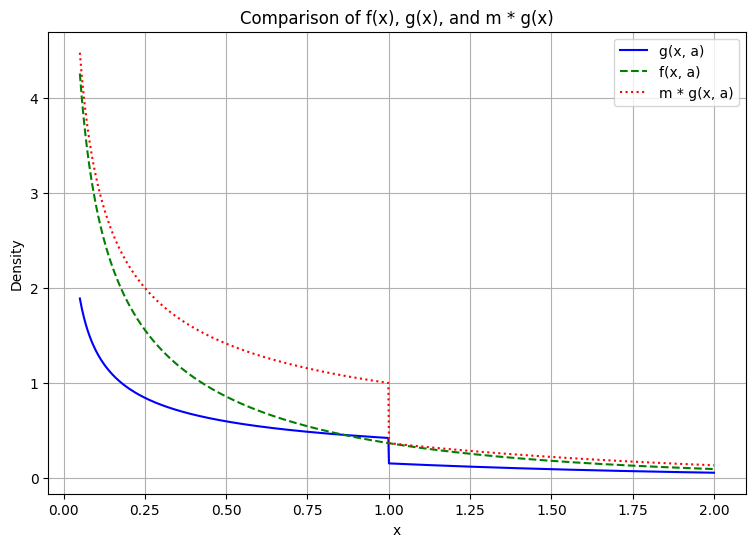

In [197]:
def gamma_rejection_factor(a):
    """
    Calculate the rejectioon factor 'm' used in the rejection sampling algorithm.

    Parameters:
    - a (float): Shape parameter of the gamma distribution.

    Returns:
    - float: The normalization factor 'm'.
    """
    return (a + np.exp(1)) / (a * np.exp(1))

a_gamma = 0.5
m = gamma_rejection_factor(a_gamma)
x_values = np.linspace(0.05, 2, 1000)

plt.figure(figsize=(9, 6))
plt.plot(x_values, gamma_auxiliary_density(x_values, a_gamma), label='g(x, a)', color='blue', linestyle='-')
plt.plot(x_values, gamma_unnormalized_density(x_values, a_gamma), label='f(x, a)', color='green', linestyle='--')
plt.plot(x_values, m * gamma_auxiliary_density(x_values, a_gamma), label='m * g(x, a)', color='red', linestyle=':')
plt.title("Comparison of f(x), g(x), and m * g(x)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## Simulation of $X$ from $\gamma(a)$

To simulate $X \sim \gamma(a)$, we simulate $(U_n, V_n)_{n \geq 1}$ such that

- $U_n \sim U([0,1])$ (uniform distribution on $[0,1]$),
- $V_n \sim \nu$ with density $g(x)$.

The procedure is as follows:

1. Define
   $
   \tau_1 = \inf\{k \geq 0 \mid U_k \leq \frac{f}{mg}(V_k)\}
   $

2. Recursively
   $
   \tau_{n+1} = \inf\{k \geq \tau_n \mid U_k \leq \frac{f}{mg}(V_k)\}
   $

3. Set
   $
   X_n = V_{\tau_n} \sim \gamma(a)
   $

---

## How to Simulate the Density $g$

We generate samples from $g(x)$ by inverting its cumulative distribution function $G(t) = \mathbb{P}(X \leq t)$, which is given by

$$
G(t) = \int_{-\infty}^t \frac{ae}{a + e} \left( x^{a-1} \mathbb{1}_{[0,1)} + e^{-x} \mathbb{1}_{[1, \infty)} \right) dx
$$

This simplifies to

$$
G(t) =
\begin{cases}
\frac{e}{a + e} t^a & \text{if } t < 1 \\
\frac{e}{a + e} + \frac{ae}{a + e} \left(\frac{1}{e} - e^{-t}\right) & \text{if } t \geq 1
\end{cases}
$$

### Inverting $G(t)$

1. For $t < 1$, solve $G(t) = u$
   $$
   \frac{e}{a + e} t^a = u \implies t = \left(\frac{a + e}{e} u\right)^{\frac{1}{a}}
   $$

   This holds when
   $$
   \left(\frac{a + e}{e} u\right)^{\frac{1}{a}} < 1 \implies u < \frac{e}{a + e}
   $$

2. For $t \geq 1$, solve $G(t) = u$
   $$
   \frac{e}{a + e} + \frac{ae}{a + e} \left(\frac{1}{e} - e^{-t}\right) = u
   \implies t = -\ln\left(\frac{a + e}{ae}(1 - u)\right)
   $$

   This holds when
   $$
   -\ln\left(\frac{a + e}{ae}(1 - u)\right) \geq 1 \implies u \geq \frac{e}{a + e}
   $$

### Final Formula for $G^{-1}(u)$

For any $u \in (0,1)$, the inverse is

$$
G^{-1}(u) = \left(\frac{a + e}{e} u\right)^{\frac{1}{a}} \mathbb{1}_{u < \frac{e}{a + e}}
- \ln\left(\frac{a + e}{ae}(1 - u)\right) \mathbb{1}_{u \geq \frac{e}{a + e}}
$$

Thus, if $U \sim U([0,1])$, then $G^{-1}(U) \sim \nu$.

In [198]:
def simulate_gamma_auxiliary_density(n, a):
    """
    Simulate random samples from the auxiliary density g(x).

    The simulation is based on the inversion method using the cumulative
    distribution function (CDF) of g(x). The CDF has two branches depending
    on the value of a uniform random variable U.

    Parameters:
    - a (float): Shape parameter of the gamma distribution.
    - n (int): Number of samples to generate. Default is 1.

    Returns:
    - np.ndarray: Array of simulated samples from g(x).
    """
    U = np.random.uniform(0, 1, n)
    indicatrice = U < np.exp(1) / (a + np.exp(1))
    branch_1 = ((a + np.exp(1)) / np.exp(1) * U) ** (1 / a)
    branch_2 = -np.log((a + np.exp(1)) / (a * np.exp(1)) * (1 - U))

    return branch_1 * indicatrice + branch_2 * (1 - indicatrice)

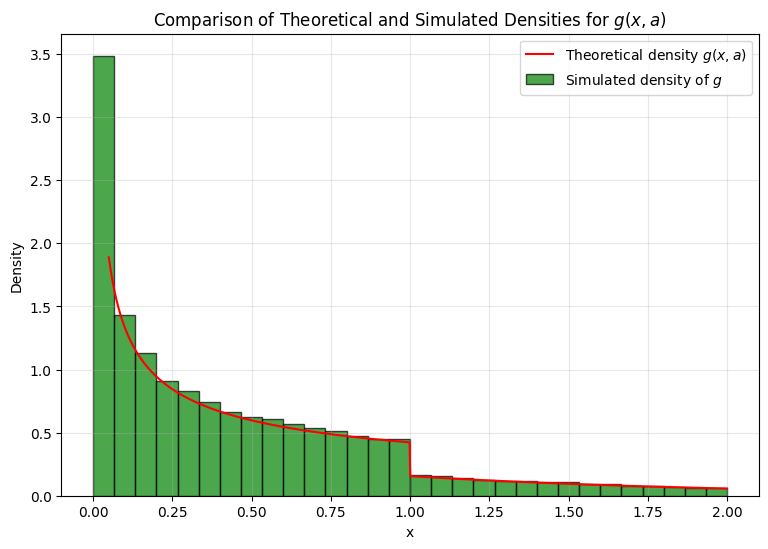

In [199]:
g_sim = simulate_gamma_auxiliary_density(100000, 0.5)

x = np.linspace(0.05, 2, 1000)

plt.figure(figsize = (9, 6))

plt.plot(x, gamma_auxiliary_density(x, a_gamma), label='Theoretical density $g(x, a)$', color='red')

plt.hist(g_sim, bins=30, range=(0, 2), density=True, label="Simulated density of $g$", color='green', alpha=0.7, edgecolor='black')

plt.xlabel('x')
plt.ylabel('Density')
plt.title(f"Comparison of Theoretical and Simulated Densities for $g(x, a)$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [200]:
def gamma_(n, a):
    V = simulate_gamma_auxiliary_density(n, a)
    f = gamma_unnormalized_density(V, a)
    g = gamma_auxiliary_density(V, a)

    return V, f, g

def simulate_rejection_density(m, unnormalized_density, auxiliary_density, n):
    """
    Simulate `n` samples from the Gamma distribution with shape parameter `a`
    using the acceptance-rejection method and estimate Gamma(a).

    Parameters:
    - a (float): Shape parameter of the Gamma distribution.
    - n (int): Number of samples to generate.

    Returns:
    - np.ndarray: Array of simulated samples from the Gamma distribution.
    - float: Estimated value of Gamma(a).
    """

    U = np.random.uniform(0, 1, size=n)

    ratio = unnormalized_density / (m * auxiliary_density)

    accepted = U <= ratio

    P_accept = np.mean(accepted)
    estimated_normalization_factor = m * P_accept

    return U, accepted, estimated_normalization_factor

## Functions to display the results

In [201]:
def plot_acceptance_rejection(U, V, accepted, m, unnormalized_density, auxiliary_density, *args):
    """
    Visualizes the acceptance-rejection sampling process.

    Parameters:
    - U (np.ndarray): An array of uniform random numbers used to determine acceptance or rejection.
    - V (np.ndarray): Samples generated from the auxiliary density g(x).
    - accepted (np.ndarray): A boolean array where `True` indicates that a sample was accepted and `False` indicates rejection.
    - m (float): The normalization factor such that \( f(x) \leq m \cdot g(x) \), where f(x) is the target density.
    - unnormalized_density (callable): A function that computes the unnormalized target density \( f(x) \).
    - auxiliary_density (callable): A function that computes the auxiliary density \( g(x) \).
    - *args: Additional arguments passed to the `unnormalized_density` and `auxiliary_density` functions (e.g., distribution parameters).
    """
    plt.figure(figsize=(9, 6))

    plt.scatter(V[~accepted], U[~accepted], c='red', alpha=0.3, label='Rejected points', s=10)

    plt.scatter(V[accepted], U[accepted], c='green', alpha=0.2, label='Accepted points', s=10)

    x_range = np.linspace(np.min(V), np.max(V), 1000)
    ratio_curve = unnormalized_density(x_range, *args) / (m * auxiliary_density(x_range, *args))
    ratio_curve = ratio_curve / np.max(ratio_curve)  # Normalize for visualization

    plt.plot(x_range, ratio_curve, 'b-', label='Ratio curve', alpha=0.7, linewidth=2)

    plt.xlabel('V (values from auxiliary density)')
    plt.ylabel('U (uniform random values)')
    plt.title('Acceptance-Rejection Process')

    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    acceptance_rate = np.mean(accepted)
    plt.text(
        0.02, 0.98,
        f'Acceptance rate: {acceptance_rate:.2%}\nAccepted points: {np.sum(accepted)}/{len(accepted)}',
        transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top'
    )

    plt.tight_layout()
    plt.show()

def plot_distribution(accepted_samples, V, theoretical_density, *args):
    """
    Visualizes the distribution of accepted samples and compares it to the theoretical density.

    Parameters:
    - accepted_samples (np.ndarray): Array of samples that were accepted during the acceptance-rejection process.
    - V (np.ndarray): Array of values sampled from the auxiliary density, used to determine the range of the plot.
    - theoretical_density : A theoretical probability density function (e.g., Gamma, Beta) that provides the `pdf` method.
    - *args: Additional arguments passed to the `theoretical_density.pdf` method (e.g., shape parameters).
    """
    plt.figure(figsize = (9,6))

    plt.hist(accepted_samples, bins=50, density=True, alpha=0.7, label='Accepted samples', color='green', edgecolor='black')

    x = np.linspace(0.01, max(V), 1000)
    theoretical_pdf = theoretical_density.pdf(x, *args)
    plt.plot(x, theoretical_pdf, 'r-', label='Theoretical Gamma density')

    plt.xlabel('x', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title('Comparaison of Theoretical and Simulated Gamma Density')
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## Results for $\gamma(a)$

In [203]:
a_gamma = 0.5
n = 10000

sample, f_gamma, g_gamma = gamma_(n, a_gamma)
m = gamma_rejection_factor(a_gamma)
U, accepted, estimated_normalization_factor = simulate_rejection_density(m, f_gamma, g_gamma, n)

In [204]:
print(f"Estimated value of Gamma({a_gamma}): {estimated_normalization_factor}")
print(f"True value of Gamma({a_gamma}): {gamma_function(a_gamma)}")

Estimated value of Gamma(0.5): 1.7595712127344987
True value of Gamma(0.5): 1.7724538509055159


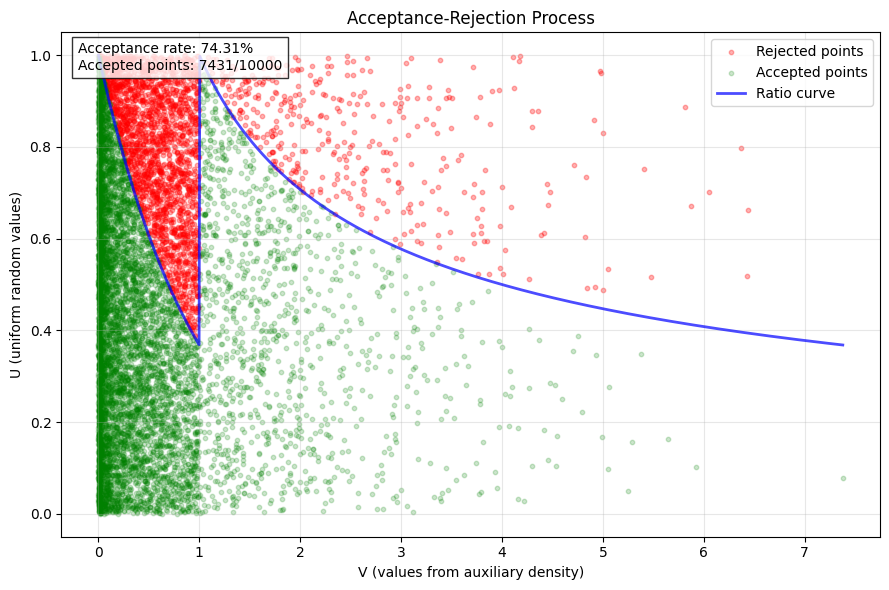

In [205]:
plot_acceptance_rejection(U, sample, accepted, m, gamma_unnormalized_density, gamma_auxiliary_density, a_gamma)

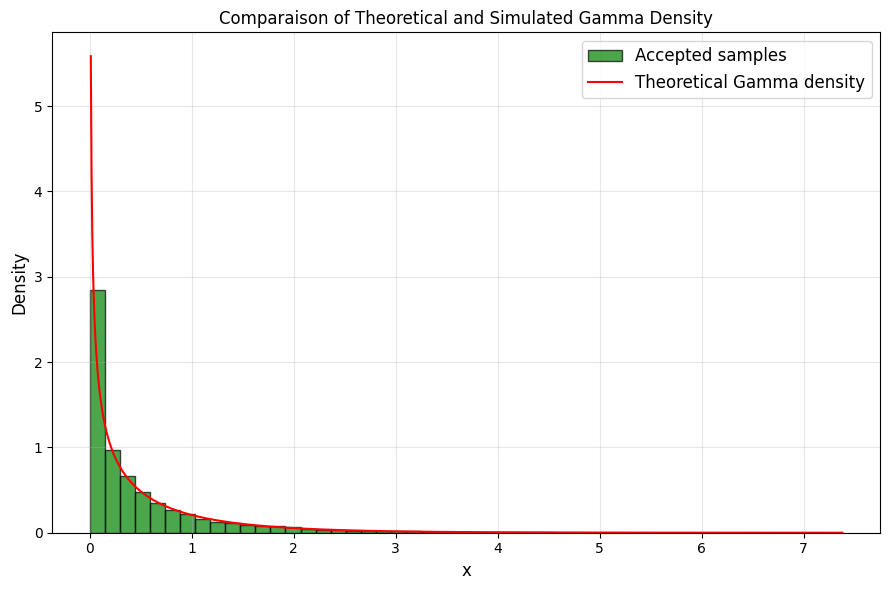

In [206]:
plot_distribution(sample[accepted], sample, gamma, a_gamma)

## Estimating the Normalization Constant with the Sampling Method

In our simulation, we can use the samples to estimate the normalization constant of the probability density function (PDF).

It’s interesting to see how the accuracy of this estimation improves as we take more and more samples.

In [207]:
def estimate_normalization_constante(*args, n_max, n_step, density, rejection_factor, confidence_level = 0.95):
    n_estimates = []
    normalization_constante_estimates = []
    confidence_intervals = []

    for n in tqdm(range(1, n_max, n_step)):
        # Store multiple estimates for each n to compute variance
        current_estimates = []
        for _ in range(30):  # Number of replications for each n
            sample, f, g = density(n, *args)
            m = rejection_factor(*args)
            _, _, estimated_factor = simulate_rejection_density(m, f, g, n)
            current_estimates.append(estimated_factor)

        mean_estimate = np.mean(current_estimates)
        std_error = np.std(current_estimates, ddof=1) / np.sqrt(len(current_estimates))
        z_score = norm.ppf((1 + confidence_level) / 2)
        ci_lower = mean_estimate - z_score * std_error
        ci_upper = mean_estimate + z_score * std_error

        n_estimates.append(n)
        normalization_constante_estimates.append(mean_estimate)
        confidence_intervals.append((ci_lower, ci_upper))

    return np.array(n_estimates), np.array(normalization_constante_estimates), np.array(confidence_intervals)

def plot_beta_estimation_with_ci(n_estimates, beta_estimates, confidence_intervals, true_value, pdf):
    plt.figure(figsize=(10, 6))

    plt.plot(beta_estimates, label=f'Estimated Value {pdf}', color='tab:blue')

    plt.fill_between(range(len(beta_estimates)),
                    confidence_intervals[:, 0],
                    confidence_intervals[:, 1],
                    color='tab:blue', alpha=0.2,
                    label=f'95% Confidence Interval')

    plt.axhline(y = true_value, color='tab:red', linestyle='--', label=f'True Value {pdf}')

    plt.title(f'Normalization Factor Estimation of {pdf}')
    plt.xlabel('Sample Size')
    plt.ylabel('Normalization Factor')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    xticks = np.arange(0, len(beta_estimates), 20)
    xtick_labels = n_estimates[::20]
    plt.xticks(ticks=xticks, labels=xtick_labels)

    plt.tight_layout()
    plt.show()

100%|██████████| 100/100 [00:00<00:00, 174.93it/s]


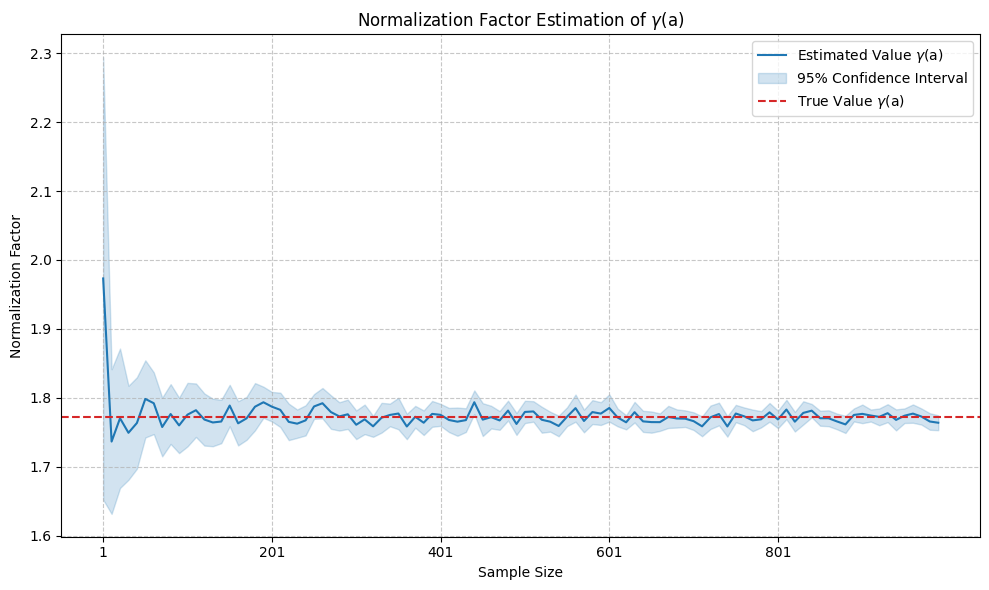

In [208]:
n_max = 1000
n_step = 10
gamma_parameters = (a_gamma,)
n_estimates, gamma_estimates, confidence_intervals = estimate_normalization_constante(*gamma_parameters,
                                                                                      n_max = n_max,
                                                                                      n_step = n_step,
                                                                                      density = gamma_,
                                                                                      rejection_factor = gamma_rejection_factor,
                                                                                      confidence_level = 0.95,
                                                                                      )
true_value = gamma_function(a_gamma)
plot_beta_estimation_with_ci(n_estimates, gamma_estimates, confidence_intervals, true_value, pdf = r'$\gamma$(a)')

# How to Simulate a $B(\alpha, \beta)$ Distribution

We aim to simulate a random variable $X \sim B(\alpha, \beta)$, whose probability density function is given by

$$
B(x, \alpha, \beta) = \frac{1}{B(\alpha,\beta)} x^{\alpha - 1} (1 - x)^{\beta - 1} \mathbb{1}_{]0, 1[}
$$

Let us define the unnormalized density function$

$$
f(x) = x^{\alpha - 1} (1 - x)^{\beta - 1} \mathbb{1}_{]0, 1[}
$$

## Bounding $f(x)$

We can derive that the function is bounded only for $\alpha > 1$ and $\beta > 1$, meaning that the rejection sampling method will only work in this case.

Moreover we have $\forall x \in ]0,1[$

$$
f'(x) = -(1 - x)^{-2 + b} x^{-2 + a} (1 - a + (a + b - 2)x)
$$

and $f'(x) = 0 \implies x = \frac{\alpha - 1}{\alpha + \beta - 2}$

Thus $f(x) \leq f(\frac{\alpha - 1}{\alpha + \beta - 2}) = \underbrace{(\frac{\alpha - 1}{\alpha + \beta - 2})^{\alpha - 1} (1 - \frac{\alpha - 1}{\alpha + \beta - 2})^{\beta - 1}}_{m} \mathbb{1}_{]0, 1[} = m g(x)$

With $g(x) = \mathbb{1}_{]0, 1[}$ the density function of $U(]0,1[)$

In [209]:
def beta_unnormalized_density(x, a, b):
    """
    Compute the unnormalized density of the gamma distribution.
    """
    return x ** (a - 1) * (1 - x)** (b-1)

def beta_auxiliary_density(x, a, b):
    """
    Compute the auxiliary density function g(x) used for rejection sampling.
    """
    return np.ones_like(x)

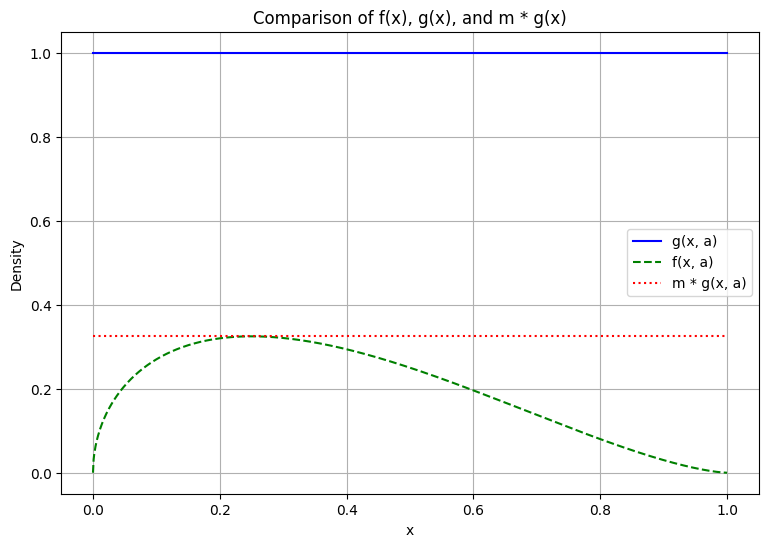

In [210]:
def beta_rejection_factor(alpha, beta):
    """
    Calculate the rejection factor 'm' used in the rejection sampling algorithm
    """
    if alpha <= 1 or beta <= 1:
        raise ValueError("Parameters must greater than 1")

    mode = (alpha - 1) / (alpha + beta - 2)
    m = mode ** (alpha-1) * (1 - mode) ** (beta-1)
    return m

a_beta = 1.5
b_beta = 2.5
m = beta_rejection_factor(a_beta, b_beta)
x = np.linspace(0, 1, 1000)

plt.figure(figsize=(9, 6))
plt.plot(x, beta_auxiliary_density(x, a_beta, b_beta), label='g(x, a)', color='blue', linestyle='-')
plt.plot(x, beta_unnormalized_density(x, a_beta, b_beta), label='f(x, a)', color='green', linestyle='--')
plt.plot(x, m * beta_auxiliary_density(x, a_beta, b_beta), label='m * g(x, a)', color='red', linestyle=':')
plt.title("Comparison of f(x), g(x), and m * g(x)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [211]:
def simulate_beta_auxiliary_density(a, b, n=1):
    """
    Simulate random samples from the auxiliary density g(x).
    """
    U = np.random.uniform(0, 1, n)

    return U

In [212]:
def beta_(n, a, b):
    V = simulate_beta_auxiliary_density(a, b, n)
    f = beta_unnormalized_density(V, a, b)
    g = beta_auxiliary_density(V, a, b)

    return V, f, g

## Results for $B(\alpha, \beta)$

In [213]:
a_beta = 1.5
b_beta = 2.5
n = 10000

sample, f_beta, g_beta = beta_(n, a_beta, b_beta)
m = beta_rejection_factor(a_beta, b_beta)
U, accepted, estimated_normalization_factor = simulate_rejection_density(m, f_beta, g_beta, n)

In [214]:
print(f"Estimated value of Beta{a_beta, b_beta}: {estimated_normalization_factor}")
print(f"True value of Beta{a_beta, b_beta}: {beta_function(a_beta, b_beta)}")

Estimated value of Beta(1.5, 2.5): 0.19560266276226276
True value of Beta(1.5, 2.5): 0.19634954084936207


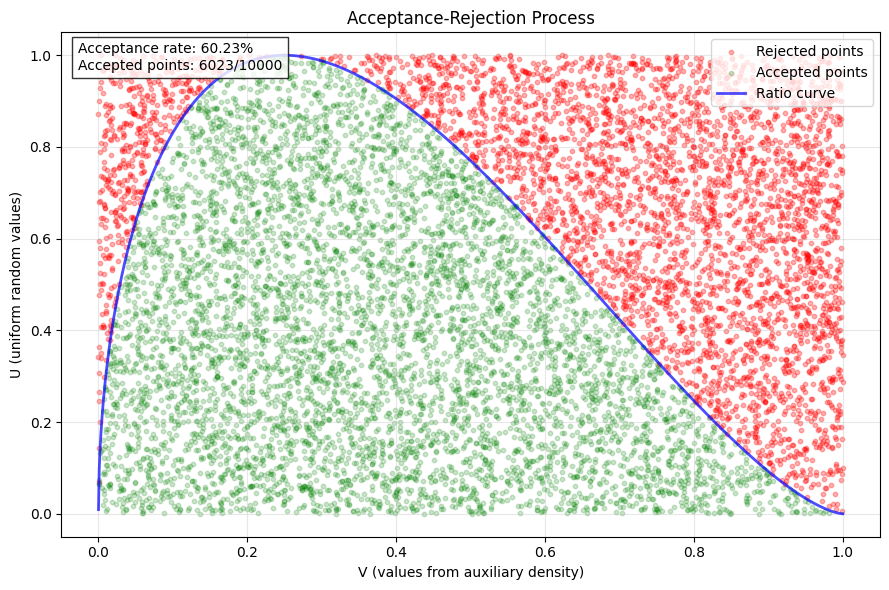

In [215]:
plot_acceptance_rejection(U, sample, accepted, m, beta_unnormalized_density, beta_auxiliary_density, a_beta, b_beta)

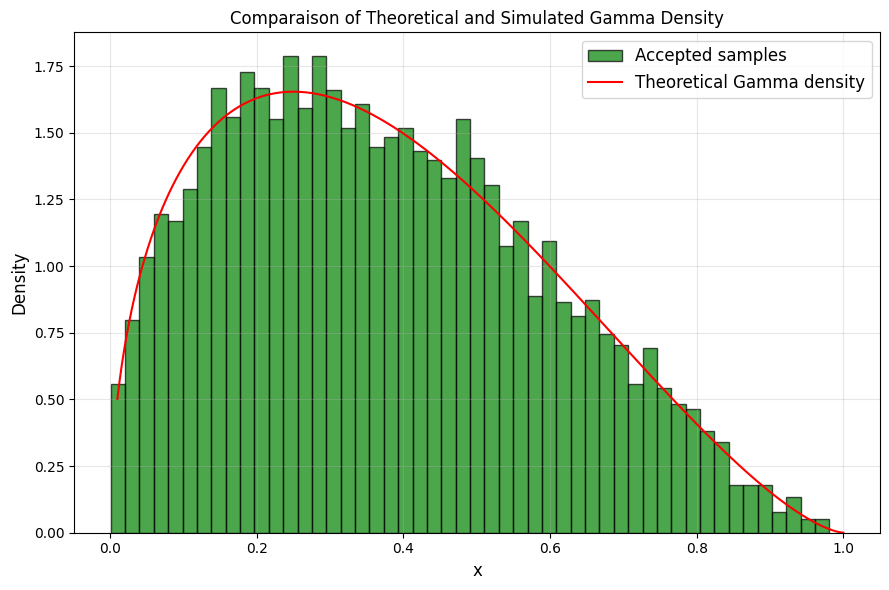

In [216]:
plot_distribution(sample[accepted], sample, beta, a_beta, b_beta)

100%|██████████| 100/100 [00:00<00:00, 418.76it/s]


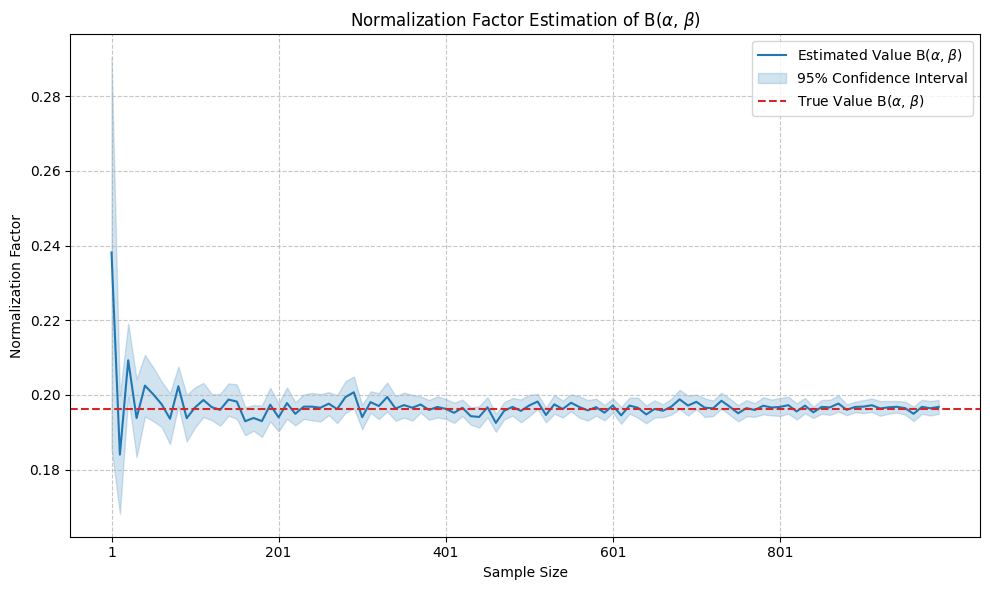

In [217]:
n_max = 1000
n_step = 10
beta_parameters = (a_beta,b_beta)
n_estimates, beta_estimates, confidence_intervals = estimate_normalization_constante(*beta_parameters,
                                                                                     n_max = n_max,
                                                                                     n_step = n_step,
                                                                                     density = beta_,
                                                                                     rejection_factor = beta_rejection_factor,
                                                                                     confidence_level = 0.95,
)
true_value = beta_function(a_beta, b_beta)
plot_beta_estimation_with_ci(n_estimates, beta_estimates, confidence_intervals, true_value, pdf = r"B($\alpha$, $\beta$)")